# Explore here

In [106]:
# Your code here
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [107]:
#Vizualisamos dataset y nos guardamos solo Latitude, Longitude y MedInc: 
df = pd.read_csv('/workspaces/pauline-K-Medias/data/raw/housing.csv')
df = df[['Latitude', 'Longitude', 'MedInc']]
df.head()

,Latitude,Longitude,MedInc
0,37.88,-122.23,8.3252
1,37.86,-122.22,8.3014
2,37.85,-122.24,7.2574
3,37.85,-122.25,5.6431
4,37.85,-122.25,3.8462


In [108]:
#Dividimos entre train/test y normalizamos porque longitude es negativa:

X = df
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 42)
X_train.head()

,Latitude,Longitude,MedInc
14196,32.71,-117.03,3.2596
8267,33.77,-118.16,3.8125
17445,34.66,-120.48,4.1563
14265,32.69,-117.11,1.9425
2271,36.78,-119.80,3.5542


Construye un K-Means: primer vamos a determinar el k optimo, que queremos usar para el modelo :


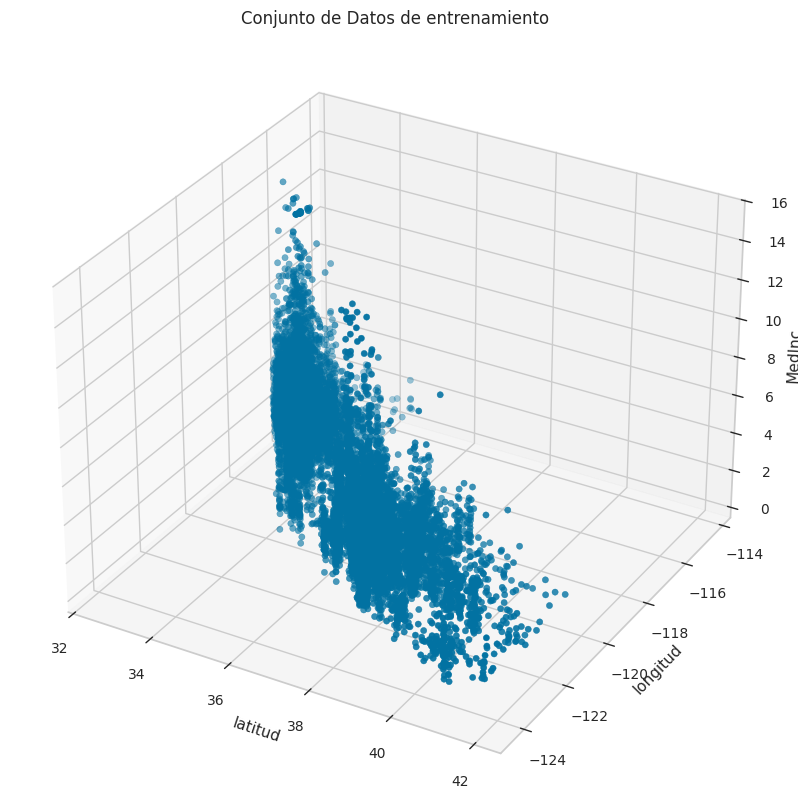

In [109]:
#Graficamos X_train en 3D como hay 3 caracteristicas :
fig = plt.figure(figsize=(12, 10)) 
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['Latitude'], X_train['Longitude'], X_train['MedInc'])

# Etiquetas
ax.set_xlabel('latitud')
ax.set_ylabel('longitud')
ax.set_zlabel('MedInc')

plt.title('Conjunto de Datos de entrenamiento')
plt.show()

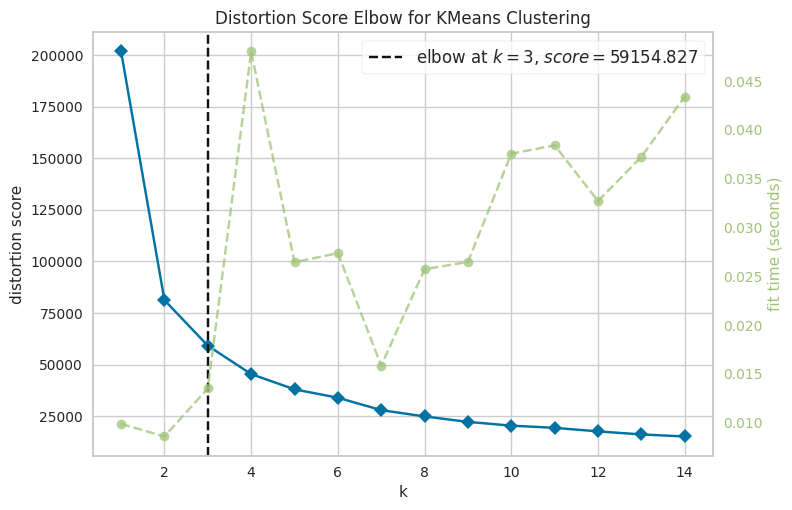

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [110]:
#Clase KElbowVisualizer para visualizar el codo (el num de cluster optimal (k))
elbow_vis = KElbowVisualizer(KMeans(random_state=42), k=(1, 15))
elbow_vis.fit(X_train)
elbow_vis.show()


Ese gráfico enseña : 
- Inercia  de los errores cuadráticos (variabilidad dentro de cada cluster; es decir, qué tan agrupados están los puntos dentro de cada grupo) en el eje Y 
- vs número de clusters (k) en el eje X

**La linea verde debería disminuir no?** Aqui vemos que hay muchos cambios en la dispersion de los puntos segun k --> hubiera tenido que escalar o no hay nada que ver? Para que no haya negativos el longitude. Igual lo intente con standardscaler y no estaba mejor.

- Codo = k optimo = **el numero de clusters optimo** = aquí es 3.

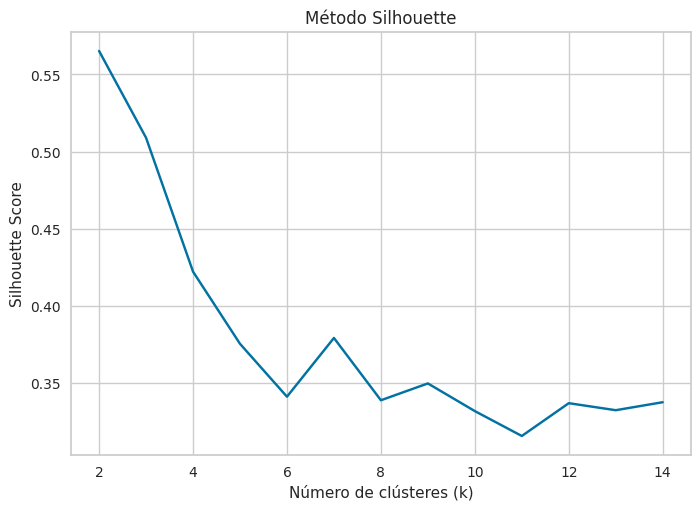

In [111]:
#Definir el rango de número de clústeres para probar 
k_values = range(2, 15)

#Inicializar listas para almacenar los valores de silhouette para cada número de clústeres
silhouette_scores = []

#Probar diferentes valores de k
for k in k_values:
  cluster_labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_train)
  silhouette_scores.append(silhouette_score(X_train, cluster_labels))

plt.plot(k_values, silhouette_scores)
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Silhouette Score')
plt.title('Método Silhouette')
plt.show()

Pico alto a k=6, con 0,65 (Solhouette score ente -1 y 1)

Son 3 clusters más que el k optimal que obtuvimos en el test anterior, pero también graficamente hay un problema con la linea verde me parece.

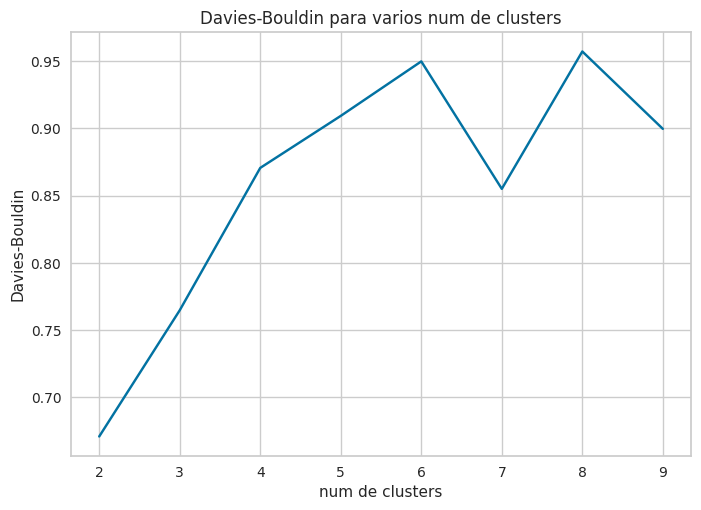

In [112]:
#Sacamos el índice Davies-Bouldin para evaluar la calidad de los clusters
num_clusters = range(2, 10)
db_scores = []

#Probar diferentes valores de k
for k in num_clusters:
    cluster_labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_train)
    db_scores.append(davies_bouldin_score(X_train, cluster_labels))

plt.plot(num_clusters, db_scores)
plt.title('Davies-Bouldin para varios num de clusters')
plt.xlabel('num de clusters')
plt.ylabel('Davies-Bouldin')
plt.show()

Igual que con el metodo silhouette, nos sale que la mejor separación entre los clusters es cuando son **10**. 

Construcción del modelo:

In [113]:
#Entrenar el modelo entonces con 10 clusters, 
model = KMeans(n_clusters = 10, random_state = 42)

#Lo aplicamos a train:
model.fit(X_train)
model.predict(X_train)



array([9, 9, 6, ..., 9, 5, 8], shape=(16512,), dtype=int32)

In [114]:
#Obtener las etiquetas de los clusters
y_train = model.labels_ #contiene las etiquetas de los clusters a los que se ha asignado cada punto de datos en el conjunto train

#Convertir X_train a df(xque es numpy.array):
X_train = pd.DataFrame(X_train)
#Añadir la columna 'cluster' como una columna categórica
X_train["cluster"] = pd.Categorical(y_train)

print(X_train.head())


       Latitude  Longitude  MedInc cluster
14196     32.71    -117.03  3.2596       9
8267      33.77    -118.16  3.8125       9
17445     34.66    -120.48  4.1563       6
14265     32.69    -117.11  1.9425       3
2271      36.78    -119.80  3.5542       6


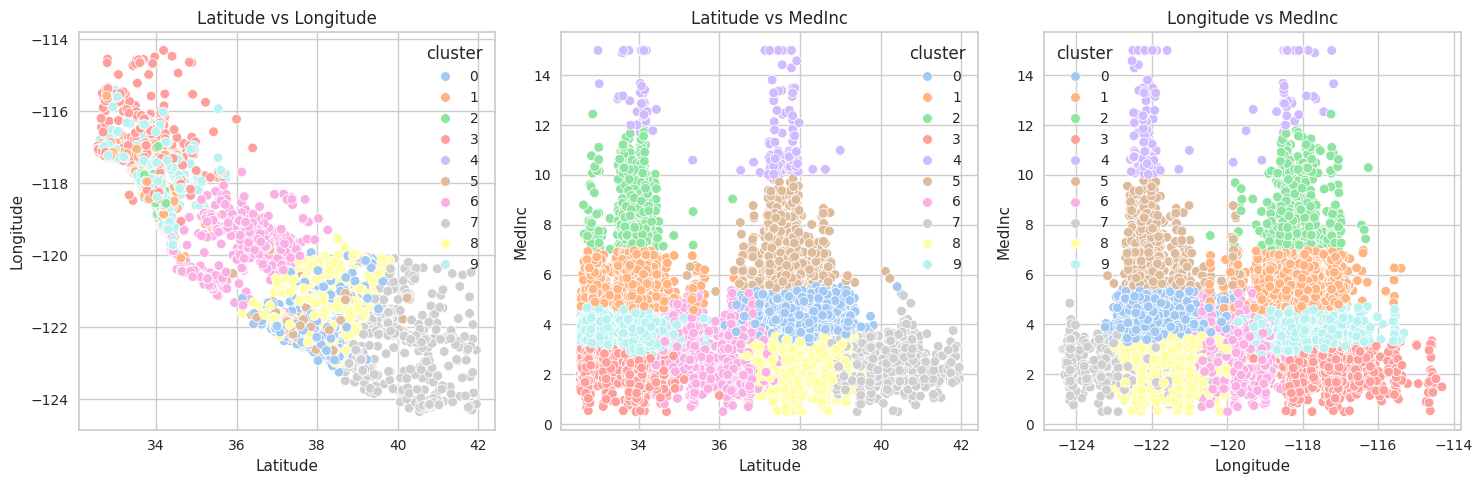

In [115]:
#Ploteamos

#Renombrar las columnas porque se han convertidas en 0,1,2
X_train.columns = ['Latitude', 'Longitude', 'MedInc', 'cluster']

# Crear los subgráficos (1 fila, 3 columnas)
fig, axis = plt.subplots(1, 3, figsize=(15, 5))

#Latitude vs Longitude
sns.scatterplot(ax=axis[0], data=X_train, x="Latitude", y="Longitude", hue="cluster", palette="pastel") # hue asigna diferentes colores a los puntos según los valores de la columna que le pases
axis[0].set_title("Latitude vs Longitude")

#Latitude vs MedInc
sns.scatterplot(ax=axis[1], data=X_train, x="Latitude", y="MedInc", hue="cluster", palette="pastel")
axis[1].set_title("Latitude vs MedInc")

#Longitude vs MedInc
sns.scatterplot(ax=axis[2], data=X_train, x="Longitude", y="MedInc", hue="cluster", palette="pastel")
axis[2].set_title("Longitude vs MedInc")

plt.tight_layout()
plt.show()


In [116]:
#Hacemos todo igual con datos de test : 
model.fit(X_test)
model.predict(X_test)

#Obtener las etiquetas de los clusters
y_test = model.labels_ #contiene las etiquetas de los clusters a los que se ha asignado cada punto de datos en el conjunto train

#Convertir X_train a df(xque es numpy.array):
X_test = pd.DataFrame(X_test)
#Añadir la columna 'cluster' como una columna categórica
X_test["cluster"] = pd.Categorical(y_test)

print(X_test.head())


       Latitude  Longitude  MedInc cluster
20046     36.06    -119.01  1.6812       5
3024      35.14    -119.46  2.5313       5
15663     37.80    -122.44  3.4801       3
20484     34.28    -118.72  5.7376       2
9814      36.62    -121.93  3.7250       1


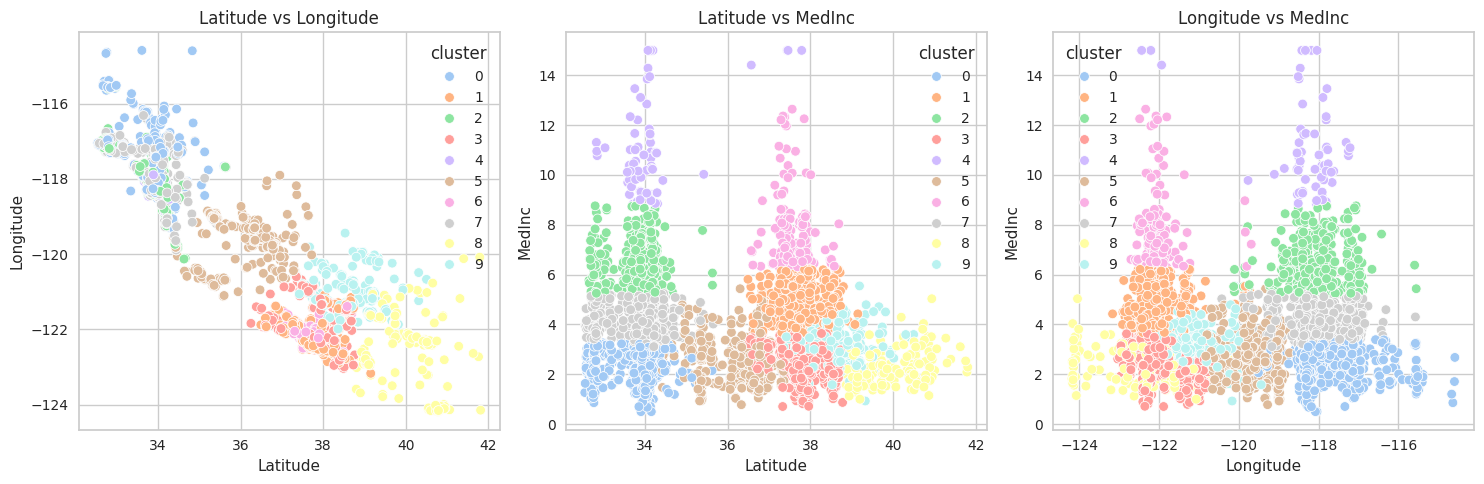

In [117]:
#Ploteamos

#Renombrar las columnas porque se han convertidas en 0,1,2
X_test.columns = ['Latitude', 'Longitude', 'MedInc', 'cluster']

# Crear los subgráficos (1 fila, 3 columnas)
fig, axis = plt.subplots(1, 3, figsize=(15, 5))

#Latitude vs Longitude
sns.scatterplot(ax=axis[0], data=X_test, x="Latitude", y="Longitude", hue="cluster", palette="pastel") # hue asigna diferentes colores a los puntos según los valores de la columna que le pases
axis[0].set_title("Latitude vs Longitude")

#Latitude vs MedInc
sns.scatterplot(ax=axis[1], data=X_test, x="Latitude", y="MedInc", hue="cluster", palette="pastel")
axis[1].set_title("Latitude vs MedInc")

#Longitude vs MedInc
sns.scatterplot(ax=axis[2], data=X_test, x="Longitude", y="MedInc", hue="cluster", palette="pastel")
axis[2].set_title("Longitude vs MedInc")

plt.tight_layout()
plt.show()


No hay ningun vinculo entre los graf de train y test ... el del train sale mal pero no logro entender porque, si tengo que cambiar algo? o sino como interpretarlo?

Vamos ahora a estudiar los resultados con el modelo de Random forest porque es un modelo de clasificación que divide los datos en función de las características, en varios árboles de decisión (que son el promedio de las predicciones de muchos árboles). Normalmente da mejores resultados que un solo árbol y lucha más contra sobreajuste.


In [ ]:
#RandomForest : 

#Primero buscamos el num de arboles de decision (n_estimadors) optimo, para optimizar ese hiperparametro:

#Diccionario con el rango de n_estimators a probar
param_grid = {'n_estimators': [10, 50, 100, 200, 500]}

#Usamos GridSearchCV :
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Ver el mejor número de estimadores
print(f"Mejor n_estimatos: {grid_search.best_params_['n_estimators']}")


In [104]:
#Entrenamos el modelo con el numero que sale: 
model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(X_train, y_train)

#Predicción
y_pred_rf = model.predict(X_test)

#Evaluar precisión
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Precisión del modelo con 10 árboles: {accuracy}")

Precisión del modelo con 10 árboles: 0.2056686046511628


In [105]:
#Me sale 39 % de accuracy ... pero claro si mi X_train está mal y muy diferente de test, es normal. 

#Que 